In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import random
import shutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2024-03-31 19:16:33.073680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 19:16:34.030548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-31 09:31:20.090237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-31 09:31:20.195753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-31 09:31:20.196003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
dataset_path="../datasets/dataset-raw-v1"
dataset_root="../datasets/"
test_sample_path="../datasets/test_samples/"

In [19]:
pokemon_names=os.listdir(dataset_path)

In [20]:
class PlotPokemon:
    @staticmethod
    def plot_a_pokemon(pokemon:str,input_shape=(64,64)):
        try:
            pokemon_image=Image.open(pokemon).resize(input_shape).convert("RGB")
            pokemon_tensor=tf.convert_to_tensor(pokemon_image)
            plt.imshow(pokemon_tensor)
            plt.axis('off') 
            plt.show()
        except Exception as err:
            print("Error: ",err)
    @staticmethod
    def plot_a_tensor(pokemon_tensor:tf.Tensor):
        try:
            plt.imshow(pokemon_tensor)
            plt.axis('off')
            plt.show()
        except Exception as err:
            print("Error:",err)
    
    @staticmethod
    def plot_pokemons(pokemons:tf.Tensor,pokemon_classes=None):
        
        n_pokemons=pokemons.shape[0]

        cols=8
        rows=int(tf.math.ceil(n_pokemons/cols).numpy())       

        
        
        fig,axis=plt.subplots(rows,cols,figsize=(25,25))
        x_index=0
        y_index=0
        plt.tight_layout()
        # print(n_pokemons)
        for index in range(n_pokemons):
            
            # print(f"index:{index}\tx:{x_index}\ty:{y_index}")
            if rows!=1:
                axis[x_index, y_index].imshow(pokemons[index,:,:,:])
                if not pokemon_classes is None:
                    axis[x_index, y_index].set_title(pokemon_classes[index])
            else:
                axis[y_index].imshow(pokemons[index,:,:,:])
                if not pokemon_classes is None:
                    axis[y_index].set_title(pokemon_classes[index])
            y_index+=1
            if y_index==cols:
                y_index%=cols
                x_index+=1
        flatten_axis=axis.flatten()
        for ax in flatten_axis[n_pokemons:]:
            ax.remove()
            
    @staticmethod
    def plot_loss(history:tf.keras.callbacks.History):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()                

plotter=PlotPokemon()

In [21]:
pokemon_img=f"{dataset_path}/Abra/10a9f06ec6524c66b779ea80354f8519.jpg"
pokemon_tensor=tf.convert_to_tensor(Image.open(pokemon_img).convert("RGB"))


In [22]:
import random
batch_dir=f"{dataset_path}/Pikachu"
pokemons=os.listdir(batch_dir)
pokemons=random.sample(pokemons,32)
pokemon_tensors=[]
for pokemon in pokemons:
    img=Image.open(f"{batch_dir}/{pokemon}").resize((64,64)).convert("RGB")
    pokemon_tensor=tf.convert_to_tensor(img)
    pokemon_tensors.append(pokemon_tensor)

pokemon_tensors=tf.convert_to_tensor(pokemon_tensors)
pokemon_tensors.shape

TensorShape([32, 64, 64, 3])

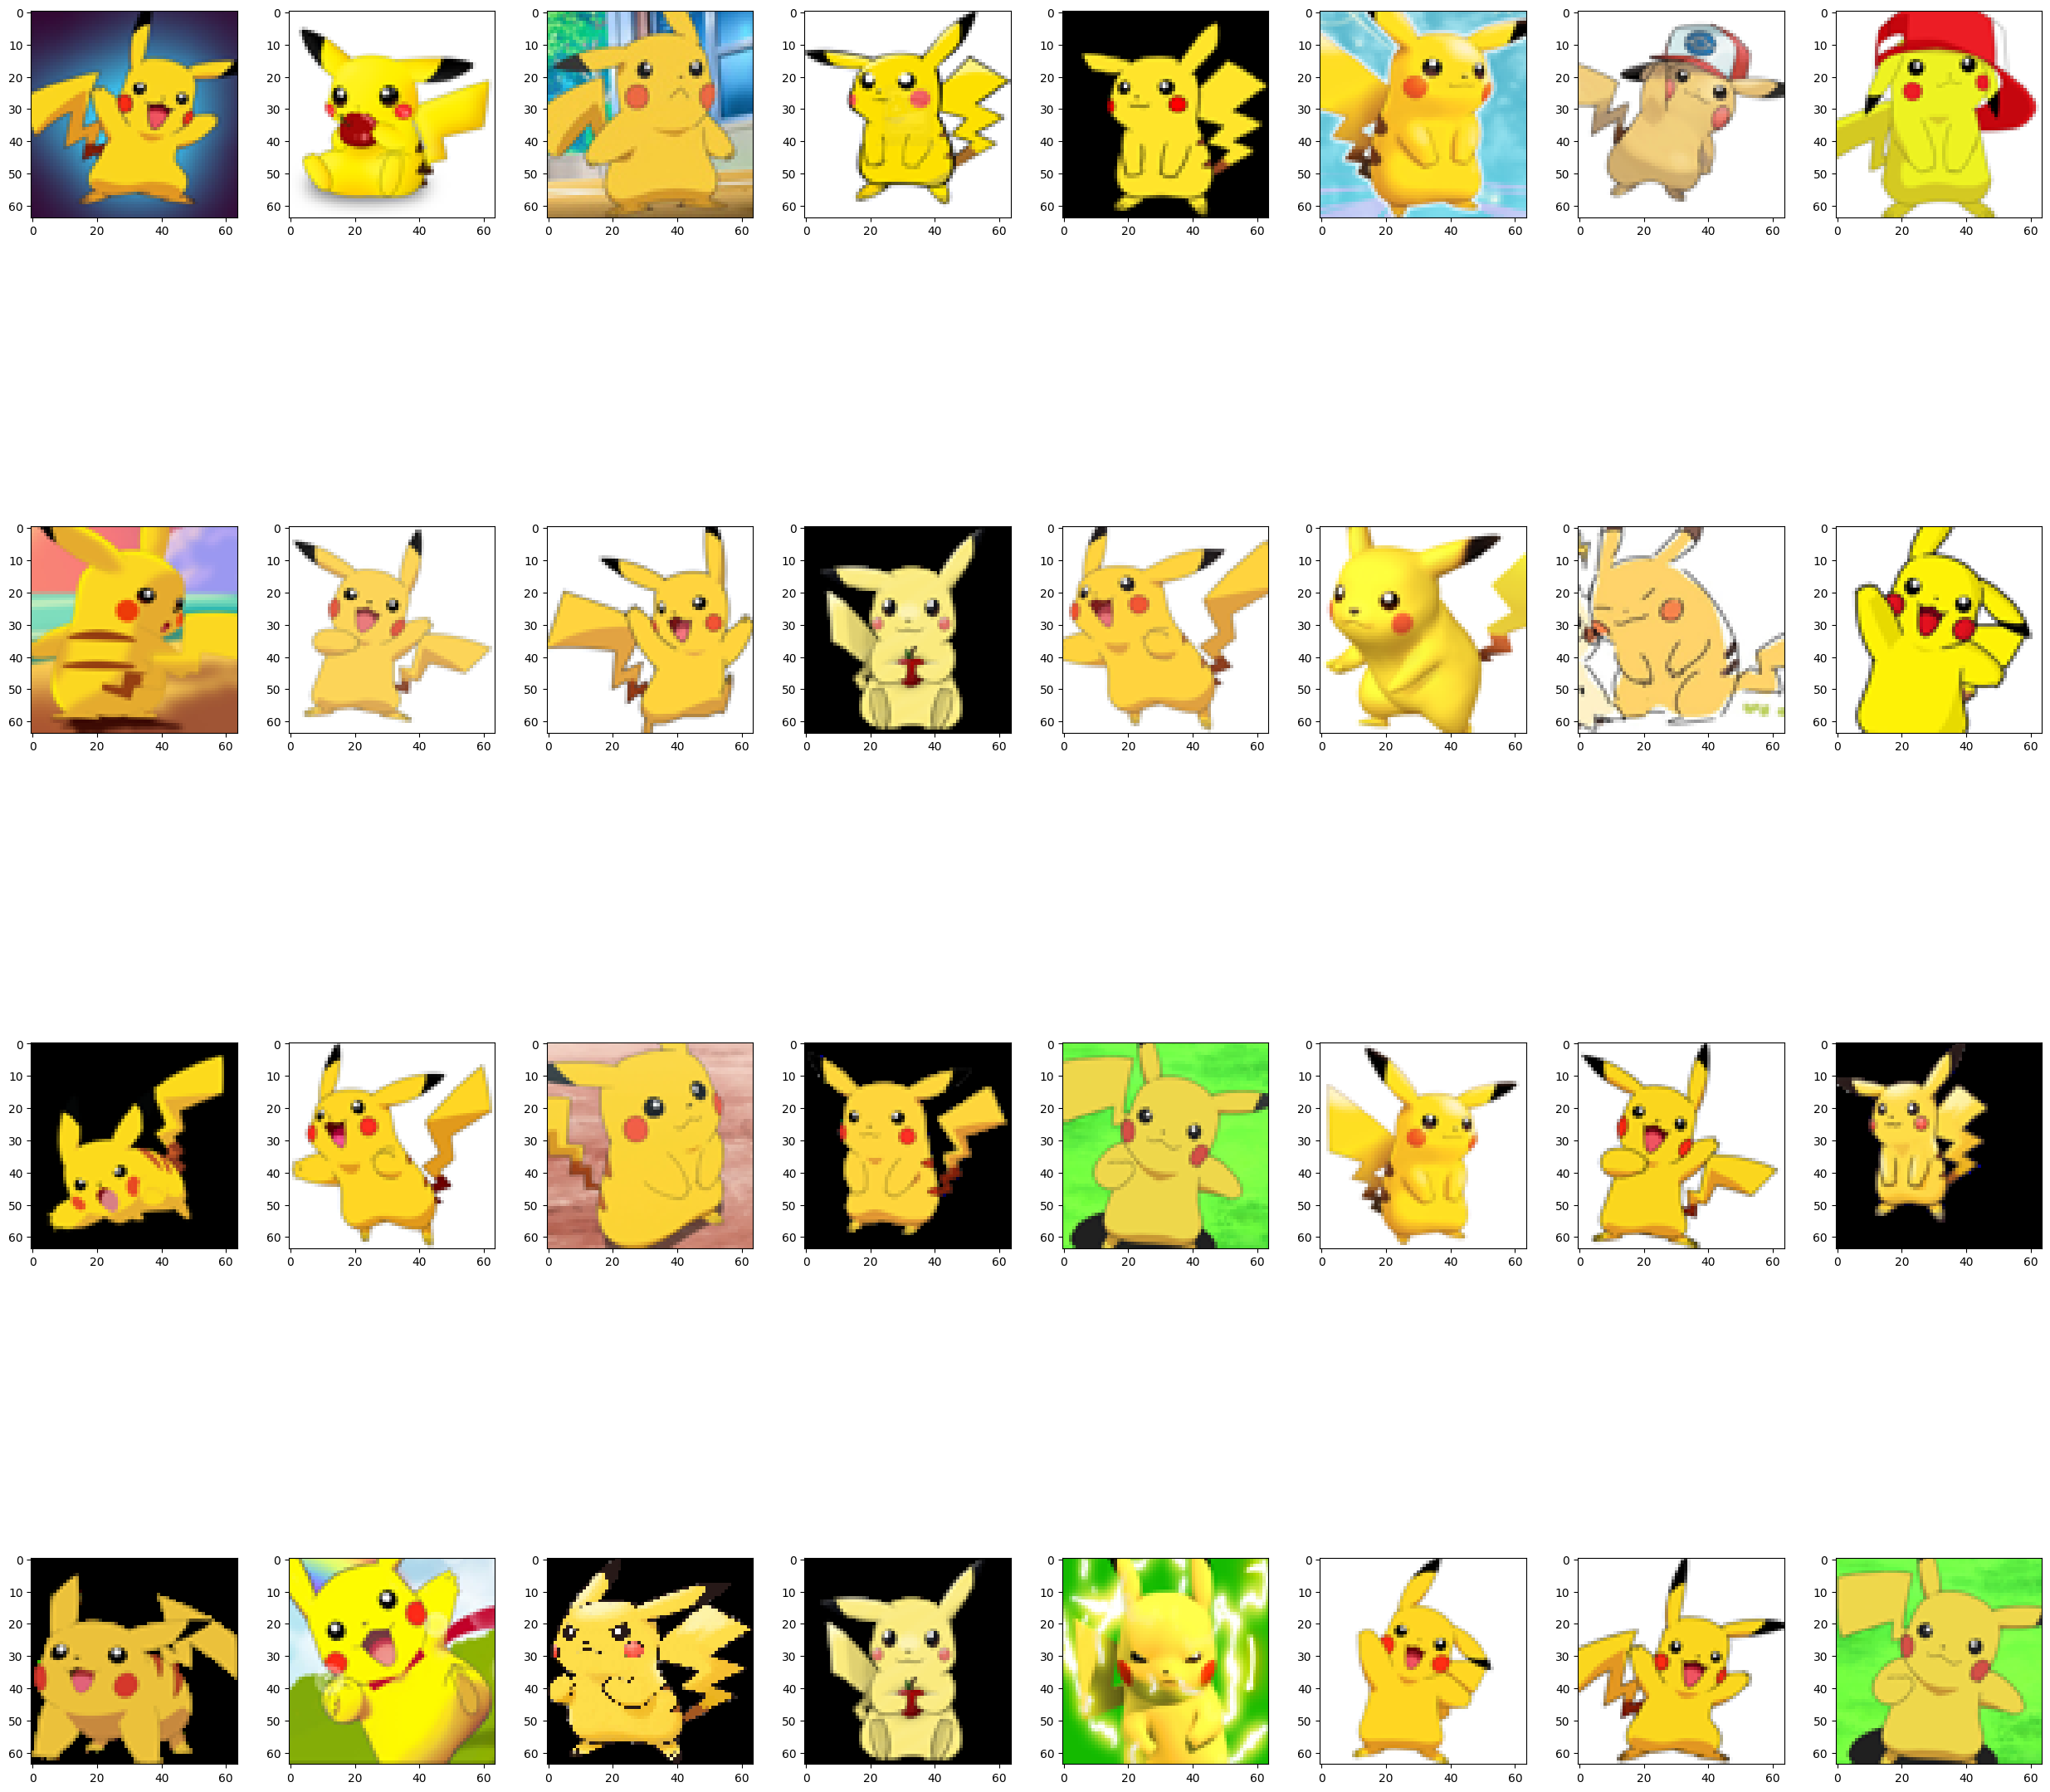

In [23]:
plotter.plot_pokemons(pokemon_tensors)

In [24]:
def create_train_and_test_ds(dataset_root_dir:str, from_dir:str):
    dataset_dir = f"{dataset_root_dir}/dataset-v1"

    if os.path.exists(dataset_dir):
        shutil.rmtree(dataset_dir)

    os.makedirs(dataset_dir, exist_ok=True)

    train_dir = f"{dataset_dir}/train"
    test_dir = f"{dataset_dir}/test"

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    pokemon_names = os.listdir(from_dir)
    for pokemon_name in pokemon_names:
        train_size = 0.8
        test_size = 1 - train_size
        pokemon_name_path = os.path.join(from_dir, pokemon_name)
        pokemon_imgs = os.listdir(pokemon_name_path)
        total_size = len(pokemon_imgs)
        train_size = max(1, int(total_size * train_size))
        test_size = total_size - train_size

        train_imgs = random.sample(pokemon_imgs, train_size)
        test_imgs = random.sample(pokemon_imgs, test_size)

        train_pokemon_dir = os.path.join(train_dir, pokemon_name)
        test_pokemon_dir = os.path.join(test_dir, pokemon_name)

        os.makedirs(train_pokemon_dir, exist_ok=True)
        os.makedirs(test_pokemon_dir, exist_ok=True)

        for train_img in train_imgs:
            train_img_source_path = os.path.join(pokemon_name_path, train_img)
            train_img_dest_path = os.path.join(train_pokemon_dir, train_img)
            shutil.copy(train_img_source_path, train_img_dest_path)

        for test_img in test_imgs:
            test_img_source_path = os.path.join(pokemon_name_path, test_img)
            test_img_dest_path = os.path.join(test_pokemon_dir, test_img)
            shutil.copy(test_img_source_path, test_img_dest_path)

In [25]:
# create_train_and_test_ds(dataset_root,dataset_path)

# Dataset Creation


In [31]:
dataset_dir="../datasets/dataset-v1"
train_dir=f"{dataset_dir}/train"
test_dir=f"{dataset_dir}/test"
batch_size=64
test_batch_size=32
input_shape=(128,128,3)
num_classes=len(os.listdir(train_dir))
num_classes

150

In [32]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
)



In [33]:
train_ds=datagen.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    target_size=(input_shape[0],input_shape[1])
)

test_ds=datagen.flow_from_directory(
    directory=test_dir,
    batch_size=test_batch_size,
    target_size=(input_shape[0],input_shape[1]),
)

Found 5391 images belonging to 150 classes.
Found 1427 images belonging to 150 classes.


# Model building

In [40]:
steps_per_epoch=int(tf.math.ceil(train_ds.n/batch_size).numpy())
test_steps=int(tf.math.ceil((test_ds.n/test_batch_size)).numpy())
steps_per_epoch,test_steps

(85, 45)

In [41]:
def create_model(num_classes, input_shape=(256, 256, 3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), bias_initializer='random_normal', activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), bias_initializer='random_normal', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), bias_initializer='random_normal', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu', bias_initializer='random_normal'),
        tf.keras.layers.Dense(256, activation='relu', bias_initializer='random_normal'),
        tf.keras.layers.Dense(num_classes, activation='softmax', bias_initializer='random_normal')
    ])
    return model


In [42]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs['accuracy']
        if acc > 0.99:
            print(f"Accuracy reached {acc * 100}% - Stopping the training.")
            self.model.stop_training = True

my_callback=MyCallback()

In [43]:
model=create_model(num_classes,input_shape)


In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [45]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')

In [47]:
history=model.fit(
    train_ds,
    batch_size=batch_size,
    validation_split=0.2,
    validation_data=train_ds,
    callbacks=[my_callback],
    steps_per_epoch=steps_per_epoch,
    validation_batch_size=test_batch_size,
    validation_steps=test_steps,
    epochs=20
)

Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.8325 - loss: 0.5256 - val_accuracy: 0.8708 - val_loss: 0.4091
Epoch 2/20


2024-03-31 19:52:22.904741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:52:22.904789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:52:22.904809: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:52:22.904830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8761 - val_loss: 0.4134
Epoch 3/20


2024-03-31 19:52:32.793338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:52:32.793367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:52:32.793379: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:52:32.793392: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 418ms/step - accuracy: 0.8540 - loss: 0.4491 - val_accuracy: 0.8837 - val_loss: 0.3673
Epoch 4/20


2024-03-31 19:53:09.957626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:53:09.957659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:53:09.957676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:53:09.957694: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8793 - val_loss: 0.3824
Epoch 5/20


2024-03-31 19:53:21.158689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:53:21.158734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:53:21.158748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:53:21.158765: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 383ms/step - accuracy: 0.8781 - loss: 0.3993 - val_accuracy: 0.8667 - val_loss: 0.4165
Epoch 6/20


2024-03-31 19:53:55.814421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:53:55.814467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:53:55.814484: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:53:55.814501: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8710 - val_loss: 0.4062
Epoch 7/20


2024-03-31 19:54:05.053746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:54:05.053774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:54:05.053786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:54:05.053798: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 404ms/step - accuracy: 0.8644 - loss: 0.4184 - val_accuracy: 0.8889 - val_loss: 0.3717
Epoch 8/20


2024-03-31 19:54:41.465064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:54:41.465091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:54:41.465102: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:54:41.465115: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8861 - val_loss: 0.3917
Epoch 9/20


2024-03-31 19:54:52.527499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:54:52.527545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:54:52.527567: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:54:52.527586: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 391ms/step - accuracy: 0.8707 - loss: 0.4325 - val_accuracy: 0.8917 - val_loss: 0.3330
Epoch 10/20


2024-03-31 19:55:27.711723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:55:27.711780: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666
2024-03-31 19:55:27.711791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8965 - val_loss: 0.3342
Epoch 11/20


2024-03-31 19:55:37.302550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:55:37.302578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:55:37.302589: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:55:37.302603: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 387ms/step - accuracy: 0.8857 - loss: 0.3829 - val_accuracy: 0.8896 - val_loss: 0.3567
Epoch 12/20


2024-03-31 19:56:12.057340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:56:12.057381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:56:12.057400: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:56:12.057417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8877 - val_loss: 0.3838
Epoch 13/20


2024-03-31 19:56:21.662154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:56:21.662185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:56:21.662198: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:56:21.662211: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 389ms/step - accuracy: 0.8891 - loss: 0.3682 - val_accuracy: 0.8920 - val_loss: 0.3401
Epoch 14/20


2024-03-31 19:56:56.407626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:56:56.407664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:56:56.407679: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:56:56.407695: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8921 - val_loss: 0.3348
Epoch 15/20


2024-03-31 19:57:05.692491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:57:05.692522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:57:05.692537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:57:05.692555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 383ms/step - accuracy: 0.8802 - loss: 0.3826 - val_accuracy: 0.9042 - val_loss: 0.3221
Epoch 16/20


2024-03-31 19:57:40.416159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:57:40.416199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:57:40.416214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:57:40.416231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9016 - val_loss: 0.3105
Epoch 17/20


2024-03-31 19:57:50.022112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:57:50.022145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:57:50.022159: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:57:50.022180: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 377ms/step - accuracy: 0.8893 - loss: 0.3317 - val_accuracy: 0.8951 - val_loss: 0.3180
Epoch 18/20


2024-03-31 19:58:23.956576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:58:23.956623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:58:23.956637: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:58:23.956653: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8961 - val_loss: 0.3431
Epoch 19/20


2024-03-31 19:58:33.848817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:58:33.848870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:58:33.848882: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:58:33.848904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 394ms/step - accuracy: 0.9009 - loss: 0.2994 - val_accuracy: 0.9087 - val_loss: 0.2940
Epoch 20/20


2024-03-31 19:59:09.324947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:59:09.324991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666
2024-03-31 19:59:09.325006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9028 - val_loss: 0.3103


2024-03-31 19:59:19.574092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-31 19:59:19.574123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-03-31 19:59:19.574136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15074318250077653311
2024-03-31 19:59:19.574150: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9084687896442374666


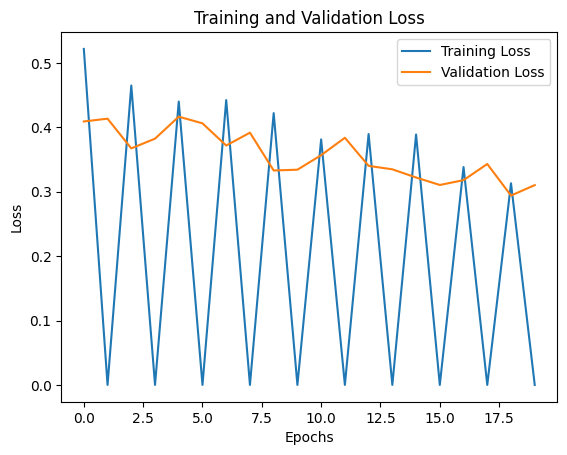

In [48]:
plotter.plot_loss(history)
#some reason every even epoch it completes the step within 90ms and returns 0 acc and 0 loss and it continues with the prev loss and acc which is around 0.3

In [49]:
model_path="../models/pokedex_128x128.keras"
model.save(model_path)
print("model saved")

model saved


In [50]:
model=tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 150)            │        38,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,738,116 (678.02 MB)

 Trainable params: 59,246,038 (226.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 118,492,078 (452.01 MB)

In [51]:
def predict_img(model:tf.keras.models.Model,ds_path:str,pokemon_labels,plot=False,n_preds:int=1):
    pokemon_names=os.listdir(ds_path)
    pokemon_names=random.sample(pokemon_names,n_preds)
    pokemon_dict = {}

    for pokemon_name in pokemon_names:
        pokemon_img_path=os.path.join(ds_path,pokemon_name)
        pokemon_img_paths=os.listdir(pokemon_img_path)
        pokemon_img=random.choice(pokemon_img_paths)
        pokemon_dict[pokemon_name]=os.path.join(pokemon_img_path,pokemon_img)
    pokemon_tensors=[]
    pokemon_classes=[]
    for pokemon, path in pokemon_dict.items():
        img = Image.open(path).resize((input_shape[0], input_shape[1])).convert("RGB")

        pokemon_tensor=tf.convert_to_tensor(img)
        pokemon_tensor=tf.cast(pokemon_tensor,dtype=tf.float32)
        pokemon_tensor/=255.
        pokemon_tensors.append(pokemon_tensor)
        pokemon_classes.append(pokemon)
    
    pokemon_tensors=tf.convert_to_tensor(pokemon_tensors)
    if plot:
        plotter=PlotPokemon()
        plotter.plot_pokemons(pokemon_tensors,pokemon_classes)
    
        
        

    predictions=model.predict(pokemon_tensors)
    #shape->n_preds,classes
    pokemon_preds={}
    for prediction in predictions:
        class_index=np.argmax(prediction)
        pokemon_class=pokemon_labels[class_index]
        pred_val=np.max(prediction)
        pokemon_preds[pokemon_class]=pred_val
    
    
    return pokemon_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


{'Zubat': 0.9954633}

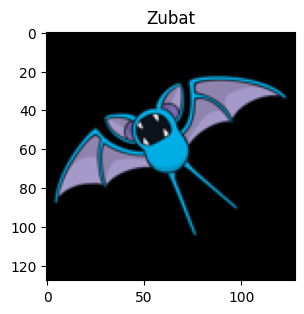

In [58]:
pokemon_classes=list(train_ds.class_indices.keys())

predict_img(model,test_dir,pokemon_labels=pokemon_classes,plot=True,n_preds=1)

(3, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
{'Dewgong': 0.7381157, 'Magnemite': 0.85336405}


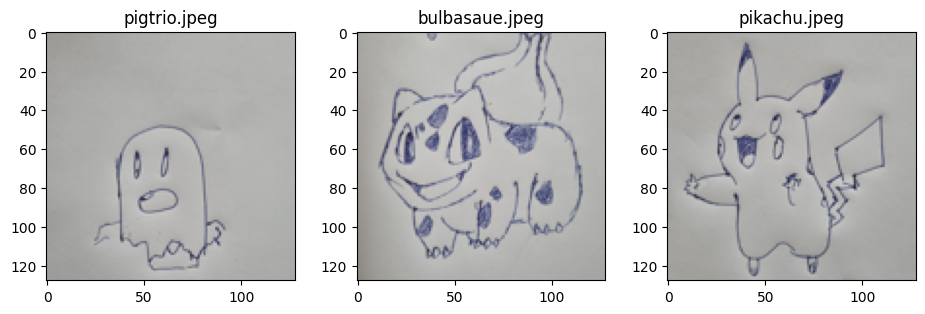

In [61]:
sample_pokemons=os.listdir(test_sample_path)
pokemon_labels=list(train_ds.class_indices.keys())
sample_pokemon_tensors=[]
for sample_pokemon in sample_pokemons:
    path=os.path.join(test_sample_path,sample_pokemon)
    img=Image.open(path).resize((128,128)).convert("RGB")
    tensor=tf.convert_to_tensor(img,dtype=tf.float32)
    tensor/=255.
    sample_pokemon_tensors.append(tensor)
tensors=tf.convert_to_tensor(sample_pokemon_tensors)
plotter=PlotPokemon()
plotter.plot_pokemons(tensors,sample_pokemons)
print(tensors.shape)
predictions=model.predict(tensors)
    #shape->n_preds,classes
pokemon_preds={}
for prediction in predictions:
    class_index=np.argmax(prediction)
    pokemon_class=pokemon_labels[class_index]
    pred_val=np.max(prediction)
    pokemon_preds[pokemon_class]=pred_val
print(pokemon_preds)